# Practica 1 Alfonso Ramos Rojas

## Cargar las librerias

- **Numpy (np)**: operaciones numéricas y manipulación de arrays; aquí se usa para crear ventanas temporales (np.lib.stride_tricks.sliding_window_view) y cálculos vectorizados.
- **Pandas (pd)**: lectura y manejo de datos tabulares/series temporales (pd.read_csv, index datetime, selección de columnas).
- **Matplotlib.pyplot (plt)**: visualización de series temporales y marcado de anomalías (plot, scatter, show).
- **Tensorflow (tf)**: framework de deep learning y backend para Keras.
- **keras.models.Sequential**: contenedor secuencial para construir la RNN/modelo.
- **keras.layers.LSTM**: capa recurrente LSTM para modelado de dependencias temporales.
- **keras.layers.Dense**: capa densa/final para producir la predicción.

In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

## 1. Contrucción de modelo LSTM y detección de anomalías

### a. Construcción del modelo básico

#### Cargar datos
Cargamos todo desde el csv de datos dado en el dataframe de pandas

In [214]:
df = pd.read_csv("datos.csv",parse_dates=True)
print("Datos cargados: \n", df.head(5))

Datos cargados: 
              timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551


#### Creamos las ventanas temporales
Aquí el parametro principal es el tamaño de ventana, que varía mucho el resultado del modelo. En un principio probé con valores bajos (3, 5) y tras hacer pruebas, he descubierto que da mejores resultados tamaños medios de ventana de ventana. Primero con 24 daba mejores resultados, pero con 12 valores por ventana da los mejores resultados para nuestros datos.


In [215]:
n_steps = 12
windows = np.lib.stride_tricks.sliding_window_view(df["value"], window_shape=(n_steps))
print("Dimensiones de ventanas: ", windows.shape)

Dimensiones de ventanas:  (7256, 12)


#### Creamos datos de entrenamiento
Usamos como datos todas las ventanas menos la última para la predicción.
Para los valores objetivos usamos el primer valor siguiente a la ventana claro, que es el que puede predecir la primera ventana.
Además de eso redimensionamos las ventanas para que las acepte el modelo

In [216]:
X = windows[:-1]
y = df["value"].values[n_steps:]
X = X.reshape((X.shape[0], X.shape[1], 1))
print("X Shape: ", X.shape)
print("Y Shape: ", y.shape)

X Shape:  (7255, 12, 1)
Y Shape:  (7255,)


#### Creamos el modelo
Creamos el modelo, con una capa de LSTM unida con una capa densa de 1 neurona al final como salida.
En primer lugar, las neuronas de la capa LSTM dan mucho mejor resultado siendo 100 en vez de 50

Además la funcion de activación sigmoide da unos resultados muy superiores a la tanh

In [217]:
model = Sequential([
	LSTM(100, activation='sigmoid', input_shape=(n_steps, 1)),
	Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

c:\Cosas\CosasPython\Practicas-Software-Critico\Practica1\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Entrenamos el modelo con las ventanas
Al principio usaba 50 epochs en el modelo, pensando que asi mejoraria mucho la calidad del modelo cuantos mas epochs use, sin embargo probando valores mas bajos, resulta que con tantisimos epochs se producia muchisimo sobre ajuste y además detectaba demasiados puntos como anomalías. Probando he encontrado que el numero óptimo de epochs es 15, manteniendo un mse medio final del modelo de aprox. 5

In [218]:
epochs = 15

history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

print("Modelo entrenado exitosamente")

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3781.6357
Epoch 2/15
 15/227 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2825.8108

c:\Cosas\CosasPython\Practicas-Software-Critico\Practica1\venv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2257.3645
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1314.8912
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 724.0807
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 378.1145
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 185.9189
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 88.3097 
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 43.9954
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 26.3539
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 20.3158
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 18.1035
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 16.1215
Epoch 13/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12.9967
Epoch 14/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.2196
Epoch 15/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1334
Modelo entrenado exitosamente


#### Graficamos la perdida para optimizar el modelo
Este gráfico lo he estado usando para comprobar el numero optimo de iteraciones del modelo. Podemos observar que para el epoch 15 la pérdida no baja casi nada, por lo que no merece la pena seguir

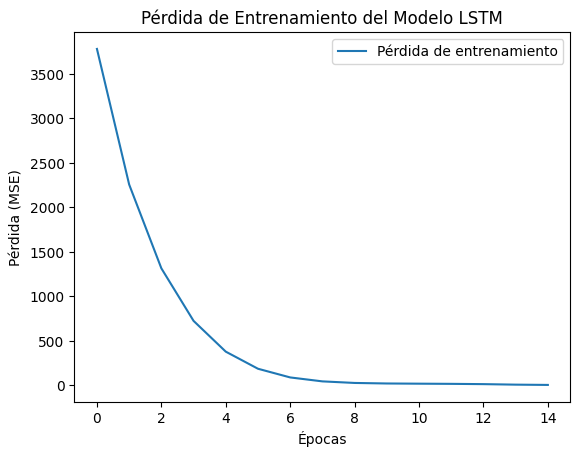

In [219]:
plt.plot(model.history.history['loss'], label='Pérdida de entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Pérdida de Entrenamiento del Modelo LSTM')
plt.legend()
plt.show()

#### Creamos los valores de prediccion
Creamos las predicciones y calculamos el error de cada predicción con respecto al valor real

In [220]:
predictions = model.predict(X)
errors = y - predictions.flatten()
print("Errores: \n", errors)

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Errores: 
 [ 0.41951988 -0.02235594 -0.52004583 ... -0.12001475 -0.47946102
  0.40273787]


### b. Detección de anomalías

#### Threshold y deteccion de anomalias
Aquí usando el **rango intercuartílico** y usando el errror de la predicción usado antes, marcamos todos los puntos que esten 1.5 veces alejados de dicho rango como anomalías. Valores mayores de 1.5 provocaban demasiados falsos positivos.

In [221]:
IRQ_DIFF = 1.5

error_IQR = np.percentile(errors, 75) - np.percentile(errors, 25)
print("Rango Intercuartil de los errores: ", error_IQR)
anomalies = np.where(np.abs(errors) > IRQ_DIFF * error_IQR)[0]
print("Número de anomalías detectadas: ", len(anomalies))
error_df = df.iloc[anomalies]

Rango Intercuartil de los errores:  1.8719428178320356
Número de anomalías detectadas:  588


#### Graficamos anomalias
Graficamos los valores originales junto a las anomalias para observar el resultado final de nuestro modelo.

Observamos que la anomalía principal en el centro del grafico la detecta sin ninguna duda, y pequeños picos anómalos al final de la gráfica también. No detecta ciertos valores que no son demasiado anómalos como los del principio de la gráfica, pero el modelo tiene un buen desempeño para ver anomalías grandes.

El numero de anomalias es 588 de 7267
                timestamp      value
142   2013-07-09 22:00:00  69.175606
342   2013-07-18 06:00:00  69.537913
648   2013-08-01 08:00:00  72.392673
671   2013-08-02 07:00:00  72.268245
768   2013-08-06 08:00:00  69.752143
...                   ...        ...
7213  2014-05-26 10:00:00  68.072276
7225  2014-05-26 22:00:00  69.023778
7226  2014-05-26 23:00:00  68.511095
7249  2014-05-27 22:00:00  69.687197
7250  2014-05-27 23:00:00  68.986959

[588 rows x 2 columns]


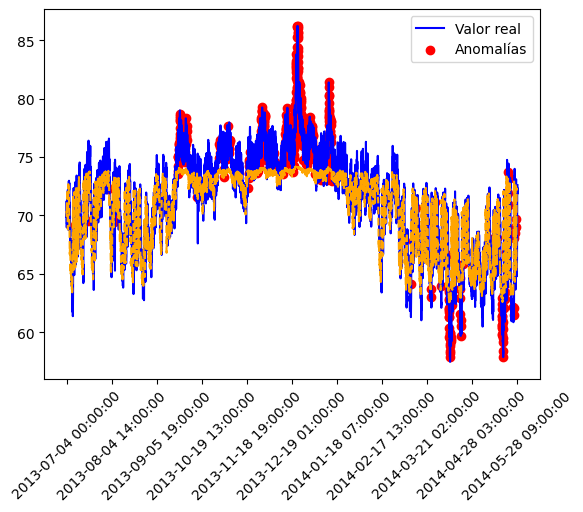

In [222]:
print(f"El numero de anomalias es {len(anomalies)} de {len(df)}")
print(df.iloc[anomalies])
plt.plot(df['timestamp'], df['value'], label='Valor real', color='blue')
plt.plot(predictions, linestyle='dashed', color='orange')
plt.scatter(
    df['timestamp'][anomalies],
    df['value'][anomalies],
    color='red',
    label='Anomalías')
plt.xticks(df['timestamp'][::len(df)//10], rotation=45)
plt.legend()
plt.show()

### c. Mejora del modelo
Los cambios que he aplicado para mejorar el modelo son los siguientes:

Principales:
- Reducir numero de epochs 50 -> 15
- Aumentar tamaño de ventana 3 -> 12

Adicionales:
- Neuronas LSTM 50 -> 100
- Funcion de activación 'tanh' -> 'sigmoid'